In [3]:
import ast
import pandas as pd
import seaborn as sns
from datasets import load_dataset
import matplotlib.pyplot as plt

dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

data_jobs.csv:   0%|          | 0.00/231M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/785741 [00:00<?, ? examples/s]

### Filtering data for India

In [4]:
df_IND = df[df['job_country'] == 'India']

In [5]:
df_skills = df_IND.explode('job_skills')

df_skills[['job_title', 'job_skills']]

,job_title,job_skills
16,Big Data Engineer,powershell
16,Big Data Engineer,python
16,Big Data Engineer,sql
16,Big Data Engineer,mysql
16,Big Data Engineer,sql server
...,...,...
785716,Application Support Analyst,c#
785716,Application Support Analyst,sql
785718,Senior Performance QA Analyst,None
785740,AWS System Analyst,aws


### Skills per job title

In [6]:
df_skills_count = df_skills.groupby(['job_skills', 'job_title_short']).size()

df_skills_count = df_skills_count.reset_index(name='skill_count')

df_skills_count.sort_values(by='skill_count', ascending=False, inplace=True)

df_skills_count

,job_skills,job_title_short,skill_count
1374,sql,Data Engineer,12993
1088,python,Data Engineer,11568
1089,python,Data Scientist,9248
1327,spark,Data Engineer,7157
103,aws,Data Engineer,6993
...,...,...,...
389,esquisse,Data Scientist,1
887,node.js,Senior Data Analyst,1
753,matlab,Cloud Engineer,1
411,fastapi,Cloud Engineer,1


### Top 3 roles

In [8]:
job_titles = df_skills_count['job_title_short'].unique().tolist()

job_titles = sorted(job_titles[:3])

job_titles

['Data Analyst', 'Data Engineer', 'Data Scientist']

### Skill counts

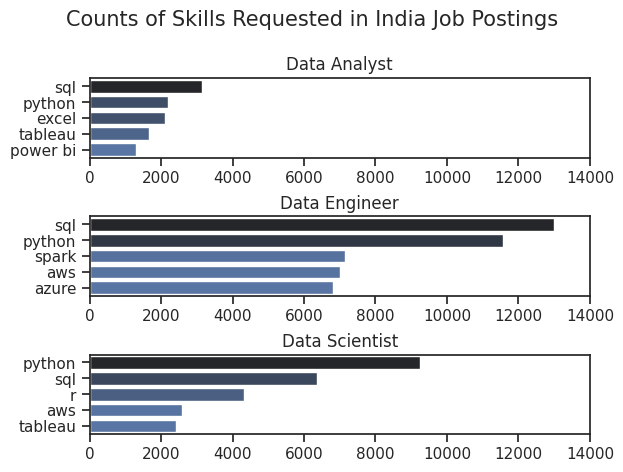

In [14]:
fig, ax = plt.subplots(len(job_titles), 1)

sns.set_theme(style='ticks')

for i, job_title in enumerate(job_titles):
    df_plot = df_skills_count[df_skills_count['job_title_short'] == job_title].head(5)[::-1]
    sns.barplot(data=df_plot, x='skill_count', y='job_skills', ax=ax[i], hue='skill_count', palette='dark:b_r')
    ax[i].set_title(job_title)
    ax[i].invert_yaxis()
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].get_legend().remove()
    ax[i].set_xlim(0, 14000)

fig.suptitle('Counts of Skills Requested in India Job Postings', fontsize=15)
fig.tight_layout(h_pad=0.5)
plt.show()

In [15]:
df_job_title_count = df_IND['job_title_short'].value_counts().reset_index(name='jobs_total')

df_job_title_count

,job_title_short,jobs_total
0,Data Engineer,19062
1,Data Scientist,13279
2,Data Analyst,6121
3,Senior Data Engineer,4353
4,Senior Data Scientist,2486
5,Business Analyst,1887
6,Software Engineer,1795
7,Senior Data Analyst,1083
8,Machine Learning Engineer,671
9,Cloud Engineer,351


In [16]:
df_skills_perc = pd.merge(df_skills_count, df_job_title_count, on='job_title_short', how='left')

df_skills_perc['skill_percent'] = (df_skills_perc['skill_count'] / df_skills_perc['jobs_total']) * 100

df_skills_perc

,job_skills,job_title_short,skill_count,jobs_total,skill_percent
0,sql,Data Engineer,12993,19062,68.161788
1,python,Data Engineer,11568,19062,60.686182
2,python,Data Scientist,9248,13279,69.643798
3,spark,Data Engineer,7157,19062,37.545903
4,aws,Data Engineer,6993,19062,36.685552
...,...,...,...,...,...
1684,esquisse,Data Scientist,1,13279,0.007531
1685,node.js,Senior Data Analyst,1,1083,0.092336
1686,matlab,Cloud Engineer,1,351,0.284900
1687,fastapi,Cloud Engineer,1,351,0.284900


### Percentage count plot

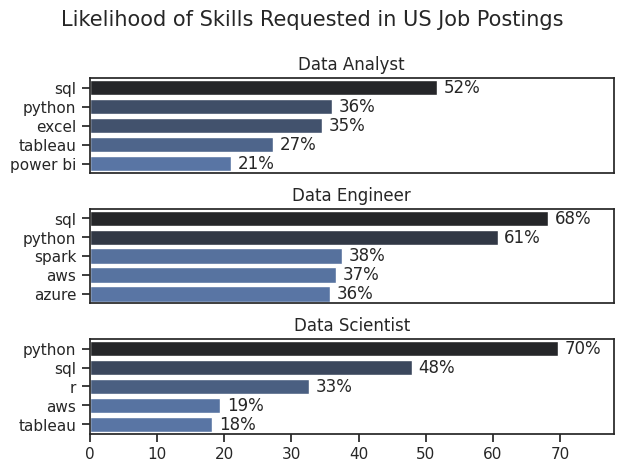

In [17]:
fig, ax = plt.subplots(len(job_titles), 1)


for i, job_title in enumerate(job_titles):
    df_plot = df_skills_perc[df_skills_perc['job_title_short'] == job_title].head(5)
    sns.barplot(data=df_plot, x='skill_percent', y='job_skills', ax=ax[i], hue='skill_count', palette='dark:b_r')
    ax[i].set_title(job_title)
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].get_legend().remove()
    ax[i].set_xlim(0, 78)

    if i != len(job_titles) - 1:
        ax[i].set_xticks([])

    for n, v in enumerate(df_plot['skill_percent']):
        ax[i].text(v + 1, n, f'{v:.0f}%', va='center')

fig.suptitle('Likelihood of Skills Requested in US Job Postings', fontsize=15)
fig.tight_layout(h_pad=.8)
plt.show()

### Grouping skills by month

In [20]:
df_DA_IND = df[(df['job_title'] == 'Data Analyst') & (df['job_country'] == 'India')].copy()

df_DA_IND['job_posted_month_no'] = df_DA_IND['job_posted_date'].dt.month

df_DA_IND_explode = df_DA_IND.explode('job_skills')

In [21]:
df_DA_IND_pivot = df_DA_IND_explode.pivot_table(index='job_posted_month_no', columns='job_skills',  aggfunc='size', fill_value=0)

df_DA_IND_pivot

job_skills,airflow,alteryx,ansible,arch,asana,asp.net,assembly,aurora,aws,azure,...,vba,visio,visual basic,vmware,watson,webex,windows,wire,word,zoom
job_posted_month_no,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,0,0,1,0,0,6,5,...,6,1,0,0,0,1,1,0,8,0
2,1,8,0,0,0,0,0,0,6,7,...,8,0,0,0,1,0,1,0,3,0
3,1,1,1,0,0,0,0,0,7,6,...,4,0,0,0,0,0,2,0,3,0
4,0,1,0,1,0,0,1,0,4,8,...,2,2,0,0,0,0,1,0,6,0
5,0,4,0,0,0,0,0,0,4,9,...,4,0,1,0,0,0,2,0,4,0
6,1,5,0,0,0,0,0,1,10,9,...,1,0,1,1,0,0,0,0,1,0
7,3,2,0,0,0,0,0,0,5,8,...,5,0,1,0,0,0,0,0,1,0
8,7,5,0,0,0,0,0,0,20,11,...,4,0,0,0,0,0,0,0,7,0
9,1,2,0,0,1,0,0,0,12,5,...,4,2,0,2,0,0,1,0,1,0


In [22]:
df_DA_IND_pivot.loc['Total'] = df_DA_IND_pivot.sum()
df_DA_IND_pivot = df_DA_IND_pivot[df_DA_IND_pivot.loc['Total'].sort_values(ascending=False).index]
df_DA_IND_pivot = df_DA_IND_pivot.drop('Total')

df_DA_IND_pivot

job_skills,sql,python,excel,tableau,power bi,sas,r,aws,azure,javascript,...,react.js,swift,ringcentral,suse,jupyter,sqlite,ggplot2,gitlab,graphql,no-sql
job_posted_month_no,,,,,,,,,,,,,,,,,,,,,
1,75,55,51,41,26,36,23,6,5,11,...,0,0,0,0,0,0,0,0,1,0
2,64,40,46,32,24,14,23,6,7,8,...,0,0,0,0,0,0,1,0,0,0
3,57,25,32,30,19,10,9,7,6,3,...,0,1,0,1,0,0,0,0,0,1
4,56,35,35,27,23,24,16,4,8,7,...,1,0,0,0,0,0,0,1,0,0
5,44,25,37,24,18,10,9,4,9,3,...,0,0,0,0,0,0,0,0,0,0
6,50,42,34,29,23,28,23,10,9,5,...,0,0,0,0,0,0,0,0,0,0
7,57,37,37,38,20,20,23,5,8,5,...,0,0,0,0,0,0,0,0,0,0
8,88,58,54,47,43,24,28,20,11,7,...,0,0,0,0,0,0,0,0,0,0
9,96,65,59,53,43,26,27,12,5,14,...,0,0,0,0,1,0,0,0,0,0


### Plotting monthly skill counts

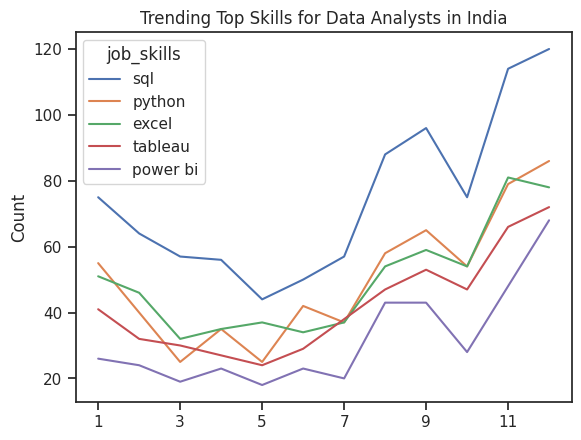

In [23]:
df_DA_IND_pivot.iloc[:, :5].plot(kind='line')

plt.title('Trending Top Skills for Data Analysts in India')
plt.ylabel('Count')
plt.xlabel('')
plt.show()

In [24]:
DA_totals = df_DA_IND.groupby('job_posted_month_no').size()

DA_totals

,0
job_posted_month_no,
1,144
2,118
3,97
4,99
5,64
6,93
7,92
8,141
9,166


In [25]:
df_DA_IND_percent = df_DA_IND_pivot.iloc[:12].div(DA_totals/100, axis=0)

df_DA_IND_percent = df_DA_IND_percent.reset_index()
df_DA_IND_percent['job_posted_month'] = df_DA_IND_percent['job_posted_month_no'].apply(lambda x: pd.to_datetime(x, format='%m').strftime('%b'))
df_DA_IND_percent = df_DA_IND_percent.set_index('job_posted_month')
df_DA_IND_percent = df_DA_IND_percent.drop(columns='job_posted_month_no')

df_DA_IND_percent

job_skills,sql,python,excel,tableau,power bi,sas,r,aws,azure,javascript,...,react.js,swift,ringcentral,suse,jupyter,sqlite,ggplot2,gitlab,graphql,no-sql
job_posted_month,,,,,,,,,,,,,,,,,,,,,
Jan,52.083333,38.194444,35.416667,28.472222,18.055556,25.000000,15.972222,4.166667,3.472222,7.638889,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.694444,0.000000
Feb,54.237288,33.898305,38.983051,27.118644,20.338983,11.864407,19.491525,5.084746,5.932203,6.779661,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.847458,0.000000,0.000000,0.000000
Mar,58.762887,25.773196,32.989691,30.927835,19.587629,10.309278,9.278351,7.216495,6.185567,3.092784,...,0.000000,1.030928,0.000000,1.030928,0.00000,0.000000,0.000000,0.000000,0.000000,1.030928
Apr,56.565657,35.353535,35.353535,27.272727,23.232323,24.242424,16.161616,4.040404,8.080808,7.070707,...,1.010101,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.010101,0.000000,0.000000
May,68.750000,39.062500,57.812500,37.500000,28.125000,15.625000,14.062500,6.250000,14.062500,4.687500,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
Jun,53.763441,45.161290,36.559140,31.182796,24.731183,30.107527,24.731183,10.752688,9.677419,5.376344,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
Jul,61.956522,40.217391,40.217391,41.304348,21.739130,21.739130,25.000000,5.434783,8.695652,5.434783,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
Aug,62.411348,41.134752,38.297872,33.333333,30.496454,17.021277,19.858156,14.184397,7.801418,4.964539,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
Sep,57.831325,39.156627,35.542169,31.927711,25.903614,15.662651,16.265060,7.228916,3.012048,8.433735,...,0.000000,0.000000,0.000000,0.000000,0.60241,0.000000,0.000000,0.000000,0.000000,0.000000


### Plotting monthly skill demand

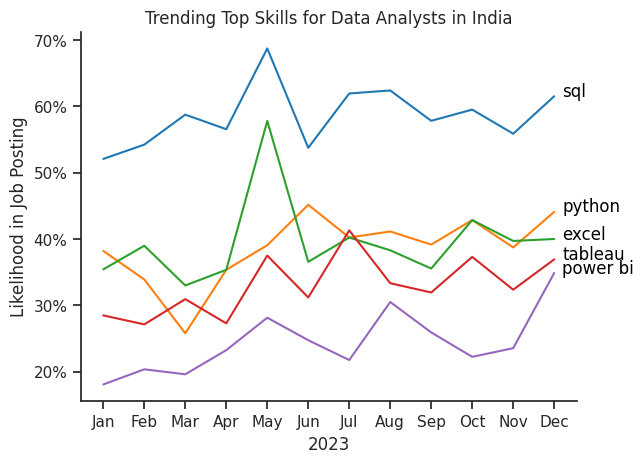

In [27]:
from matplotlib.ticker import PercentFormatter

df_plot = df_DA_IND_percent.iloc[:, :5]
sns.lineplot(data=df_plot, dashes=False, legend='full', palette='tab10')
sns.set_theme(style='ticks')
sns.despine()

plt.title('Trending Top Skills for Data Analysts in India')
plt.ylabel('Likelihood in Job Posting')
plt.xlabel('2023')
plt.legend().remove()
plt.gca().yaxis.set_major_formatter(PercentFormatter(decimals=0))

for i in range(5):
    plt.text(11.2, df_plot.iloc[-1, i], df_plot.columns[i], color='black')

plt.show()